In [1]:
%matplotlib inline

In [2]:
from matplotlib import pyplot as plt
import tensorflow as tf
import numpy as np
from IPython.display import clear_output
from ipywidgets import interact
import cv2
plt.ion()

In [3]:
# Constants

DIM = 32
IN = DIM ** 2
HIDDEN = 100
OUT = 4
GAMMA = 0.7

In [4]:
def arm(t1=0, t2=0, target_point=(0, 0)):
    img = np.zeros((DIM, DIM))
    l1, l2 = DIM/4.0, DIM/4.0
    x, y = int(DIM/2.0), int(DIM/2.0)
    x1, y1 = int(x + np.cos(t1) * l1), int(y + np.sin(t1) * l1)
    x2, y2 = int(x1 + np.cos(t2) * l2), int(y1 + np.sin(t2) * l2)
    cv2.line(img, (x, y), (x1, y1), (1))
    cv2.line(img, (x1, y1), (x2, y2), (1))
    
    dist = np.sqrt(np.square(x2 - target_point[0]) + np.square(y2 - target_point[1]))
    
    return img, dist

0.0


<function __main__.move>

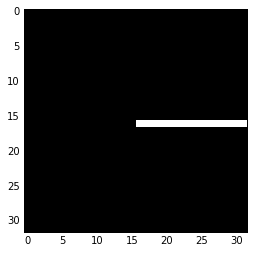

In [5]:
def move(t1=0, t2=0):
    img, dist = arm(t1, t2, (DIM, DIM/2))
    plt.imshow(img, interpolation='nearest', cmap=plt.cm.gray)
    print(dist)
    
interact(move, t1=(0, np.pi * 2.0, np.pi/4.0), t2=(0, np.pi * 2.0, np.pi/4.0))

In [6]:
def theta_update_from_action(action_index):
    dt = np.pi/4.0
    if action_index == 0:
        return (-dt, 0.0)
    elif action_index == 1:
        return (dt, 0.0)
    elif action_index == 2:
        return (0.0, -dt)
    elif action_index == 3:
        return (0.0, dt)
    
print(theta_update_from_action(3))

(0.0, 0.7853981633974483)


In [7]:
# Visualize the value of each action over thetas
def vis_avs():
    T = np.linspace(0.0, np.pi * 2.0, 20)
    
    t1s = []
    for t1 in T:
        data1, dist1 = arm(t1, 0.0, target_point)
        avs = y.eval(feed_dict={x: data1.reshape((IN, 1)), keep_prob: 1.0})
        t1s.append(avs)
    t1s = np.array(t1s)
    
    t2s = []
    for t2 in T:
        data1, dist1 = arm(0.0, t2, target_point)
        avs = y.eval(feed_dict={x: data1.reshape((IN, 1)), keep_prob: 1.0})
        t2s.append(avs)
    t2s = np.array(t2s)
    
    plt.figure(1)
    
    plt.subplot(211)
    plt.plot(t1s[:,0], c='r')
    plt.plot(t1s[:,1], c='g')
    plt.plot(t1s[:,2], c='b')
    plt.plot(t1s[:,3], c='y')
    
    plt.subplot(212)
    plt.plot(t2s[:,0], c='r')
    plt.plot(t2s[:,1], c='g')
    plt.plot(t2s[:,2], c='b')
    plt.plot(t2s[:,3], c='y')
    
# vis_avs()

In [8]:
# Define neural net
x = tf.placeholder(tf.float32, (IN, 1))
t = tf.placeholder(tf.float32, (OUT, 1))

W1 = tf.Variable(tf.random_normal((HIDDEN, IN)))
b1 = tf.Variable(tf.random_normal((HIDDEN, 1)))

W2 = tf.Variable(tf.random_normal((OUT, HIDDEN)))
b2 = tf.Variable(tf.random_normal((OUT, 1)))

h1 = tf.tanh(tf.matmul(W1, x) + b1)
keep_prob = tf.placeholder("float")
h1_drop = tf.nn.dropout(h1, keep_prob)

y = tf.matmul(W2, h1_drop) + b2

cost = tf.reduce_sum(tf.square(y - t))

In [9]:
if 'session' in globals():
    session.close()
    
session = tf.InteractiveSession()
session.run(tf.initialize_all_variables())

In [14]:
train = tf.train.GradientDescentOptimizer(0.001).minimize(cost)

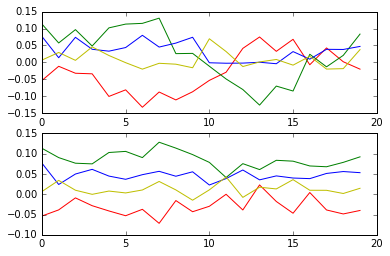

0.00800635


In [15]:
target_point = (0, DIM/2)

for i in range(20000):
    t1, t2 = np.random.random_sample() * 2.0 * np.pi, np.random.random_sample() * 2.0 * np.pi
    
    # get current state
    data1, dist1 = arm(t1, t2, target_point)
    
    # Perform random action
    rand_action = np.random.randint(0, OUT)
    
    dt1, dt2 = theta_update_from_action(rand_action)
    t1, t2 = t1 + dt1, t2 + dt2
    
    # Get new state
    data2, dist2 = arm(t1, t2, target_point)
    
    # Get reward for that action
    reward = (dist1 - dist2) / float(DIM)
    
    # Get action values for each state
    avs1 = y.eval(feed_dict={x: data1.reshape((IN, 1)), keep_prob: 1.0})
    avs2 = y.eval(feed_dict={x: data2.reshape((IN, 1)), keep_prob: 1.0})
    
    # Create target action values for first state
    target_avs = avs2 * GAMMA
    target_avs[rand_action] += reward
    
    session.run(train, feed_dict={x: data1.reshape((IN, 1)), t: target_avs, keep_prob: 0.9})
    
    if i%2000 == 0:
        c = cost.eval(feed_dict={x: data1.reshape((IN, 1)), t: target_avs, keep_prob: 1.0})
        clear_output(wait=True)
        vis_avs()
        plt.show()
        print(c)

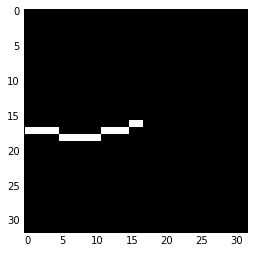

In [17]:
# Do a rollout of agent's behavior

def rollout(runs=10, iters=15):
    t1, t2 = np.random.random_sample() * 2.0 * np.pi, np.random.random_sample() * 2.0 * np.pi
    
    for i in range(runs):
        t1, t2 = np.random.random_sample() * 2.0 * np.pi, np.random.random_sample() * 2.0 * np.pi
        for i in range(iters):
            data1, dist1 = arm(t1, t2, target_point)

            avs = y.eval(feed_dict={x: data1.reshape((IN, 1)), keep_prob: 1.0})

            best_action = np.argmax(avs)

            dt1, dt2 = theta_update_from_action(best_action)
            t1, t2 = t1 + dt1, t2 + dt2

            data2, dist2 = arm(t1, t2, target_point)

            clear_output(wait=True)
            plt.imshow(data2, interpolation='nearest', cmap=plt.cm.gray)
            plt.show()
        
rollout()